### Preparatory steps

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import _functions_sql as fs
import seaborn as sns
import numpy as np
import circlify #needed for creating bubble diagrams

In [277]:
# Define lists for product categories

items = df_trade_ger.item.unique().tolist()
item_categories = world_emissions.item_category.unique().tolist()
item_groups = world_emissions.item_group.unique().tolist()

meat = list(filter(lambda x: 'Meat' in x, items))
milk_eggs= list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, items))
crops = list(set(items) - set(meat + milk_eggs))

# Create a list of 21 selected items
selected_items = ['Barley', 'Beans, dry', 'Hen eggs in shell, fresh', 'Maize (corn)', 'Meat of buffalo, fresh or chilled', 'Meat of cattle with the bone, fresh or chilled', 'Meat of chickens, fresh or chilled', 'Meat of goat, fresh or chilled', 'Meat of pig with the bone, fresh or chilled', 'Meat of sheep, fresh or chilled', 'Millet', 'Oats', 'Potatoes', 'Raw milk of cattle', 'Raw milk of sheep', 'Rice', 'Rye', 'Sorghum', 'Soya beans', 'Sugar cane', 'Wheat']

selected_meat = list(filter(lambda x: 'Meat' in x, selected_items))
selected_milk_eggs = list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, selected_items))
selected_crops = list(set(selected_items) - set(selected_meat + selected_milk_eggs) - {'Rice'}) #removing rice from the crop list since it's an outlier

In [ ]:
item_categories = world_emissions.item_category.unique().tolist()
item_groups = world_emissions.item_group.unique().tolist()
items = world_emissions.item.unique().tolist()
meat = list(filter(lambda x: 'Meat' in x, items))
milk_eggs = list(filter(lambda x: 'Raw milk' in x or 'Hen eggs' in x, items))
rice_wheat_maize = list(filter(lambda x: 'Rice' in x or 'Wheat' in x or 'Maize' in x, items))
remaining = list(set(items) - set(meat + milk_eggs + rice_wheat_maize))

In [271]:
# import production & emissions table from database
df_prod_emis = fs.get_dataframe("SELECT * from production_and_emissions_new")

In [272]:
df_prod_emis['prod_pop'] = df_prod_emis['production_in_t'] / df_prod_emis['population']
df_prod_emis['emis_pop'] = df_prod_emis['emissions_co2eq_combined_in_kt'] / df_prod_emis['population']
df_prod_emis = df_prod_emis[df_prod_emis['item_category'] != 'Live Animals']
df_prod_emis = df_prod_emis[~df_prod_emis['country'].isin(['China', 'China, Hong Kong SAR'])]

In [276]:
# Create a world production table 
world_production = df_prod_emis[(df_prod_emis.country == 'World') & (df_prod_emis.year != 2021)]

In [275]:
# Create a world emissions table
world_emissions = df_prod_emis[(df_prod_emis.country == 'World') & (df_prod_emis.year != 2021) & (df_prod_emis.emissions_co2eq_combined_in_kt.notnull())]

## Germany: production vs import volumes 

### Create a trade & production table for Germany

In [135]:
df_trade_ger = fs.get_dataframe("SELECT * FROM fao_trade_matrix WHERE reporting_country = 'Germany'")

In [136]:
df_trade_ger.head()

,reporting_country,partner_country,item_code,item,year,unit,export_quantity,export_value,import_quantity,import_value
0,Germany,Belgium,768,"Cotton, carded or combed",2022,t,0.0,NaN,0.0,NaN
1,Germany,Belgium,769,Cotton waste,2000,1000 USD,NaN,315.0,NaN,2446.0
2,Germany,Belgium,769,Cotton waste,2000,t,724.0,NaN,5359.0,NaN
3,Germany,Belgium,769,Cotton waste,2001,1000 USD,NaN,522.0,NaN,2837.0
4,Germany,Belgium,769,Cotton waste,2001,t,809.0,NaN,5964.0,NaN


In [144]:
df_production_ger = fs.get_dataframe("SELECT * FROM production_and_emissions_new WHERE country = 'Germany'")

In [145]:
df_production_ger.head()

,country,continent,subcontinent,special_area,year,population,item,item_code,item_group,item_category,...,emissions_ch4_in_kt,emissions_n2o_in_kt,emissions_co2eq_calc_in_kt,emissions_intensity_calc_in_kg_co2eq_per_kg,source_emissions,emissions_co2eq_in_kt,emissions_intensity_in_kg_co2eq_per_kg,production_emissions_in_t,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg
0,Germany,Europe,Western Europe,European Union (27),1961,73604346,Ducks,1068,Poultry Birds,Live Animals,...,0.035,0.0437,14.0026,NaN,FAO TIER 1,NaN,NaN,NaN,14.0026,NaN
1,Germany,Europe,Western Europe,European Union (27),1961,73604346,Apples,515,Fruit Primary,"Crops, primary",...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
2,Germany,Europe,Western Europe,European Union (27),1961,73604346,Apricots,526,Fruit Primary,"Crops, primary",...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
3,Germany,Europe,Western Europe,European Union (27),1961,73604346,Asparagus,367,Vegetables Primary,"Crops, primary",...,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN
4,Germany,Europe,Western Europe,European Union (27),1961,73604346,Barley,44,"Cereals, primary","Crops, primary",...,0.000,0.9128,272.0144,0.0659,FAO TIER 1,NaN,NaN,NaN,272.0144,0.0659


In [141]:
df_trade_ger_grouped = df_trade_ger.groupby(['reporting_country', 'year', 'item']).sum().reset_index()

In [151]:
df_trade_ger_grouped.head()

,year,item,item_code,export_quantity,export_value,import_quantity,import_value
0,1991,"Abaca, manila hemp, raw",9708,1.0,1.0,2180.0,5857.0
1,1991,"Almonds, in shell",7514,479.0,1083.0,2107.0,5664.0
2,1991,"Almonds, shelled",14784,3398.0,12561.0,57851.0,177504.0
3,1991,Animal oils and fats n.e.c.,46720,72506.0,20158.0,17014.0,5184.0
4,1991,Animal or vegetable fats and oils and their fr...,234416,162864.0,72361.0,85420.0,26875.0


In [143]:
df_trade_ger_grouped.drop(columns = ['reporting_country', 'partner_country', 'unit'], inplace = True)

In [146]:
df_production_ger_grouped = df_production_ger.groupby(['country', 'year','item']).sum().reset_index()

In [150]:
df_production_ger_grouped.head()

,year,item,item_code,item_group,item_category,area_harvested_in_ha,stocks_in_an,producing_animals_slaughtered_in_an,egg_or_milk_animals_in_an,production_in_t,...,emissions_ch4_in_kt,emissions_n2o_in_kt,emissions_co2eq_calc_in_kt,emissions_intensity_calc_in_kg_co2eq_per_kg,source_emissions,emissions_co2eq_in_kt,emissions_intensity_in_kg_co2eq_per_kg,production_emissions_in_t,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg
0,1961,Apples,515,Fruit Primary,"Crops, primary",0.0,0.0,0.0,0.0,851000.0,...,0.0,0.0000,0.0000,0.0000,0,0.0,0.0,0.0,0.0000,0.0000
1,1961,Apricots,526,Fruit Primary,"Crops, primary",0.0,0.0,0.0,0.0,2900.0,...,0.0,0.0000,0.0000,0.0000,0,0.0,0.0,0.0,0.0000,0.0000
2,1961,Asparagus,367,Vegetables Primary,"Crops, primary",6195.0,0.0,0.0,0.0,16300.0,...,0.0,0.0000,0.0000,0.0000,0,0.0,0.0,0.0,0.0000,0.0000
3,1961,Barley,44,"Cereals, primary","Crops, primary",1552018.0,0.0,0.0,0.0,3669020.0,...,0.0,0.9128,272.0144,0.0659,FAO TIER 1,0.0,0.0,0.0,272.0144,0.0659
4,1961,"Beans, dry",176,"Pulses, Total","Crops, primary",6737.0,0.0,0.0,0.0,12693.0,...,0.0,0.0022,0.6556,0.0459,FAO TIER 1,0.0,0.0,0.0,0.6556,0.0459


In [149]:
df_production_ger_grouped.drop(columns = ['country', 'continent', 'subcontinent', 'special_area', 'population',], inplace = True)

In [ ]:
# df_trade_prod_ger_grouped.dropna(subset = ['import_quantity', 'production_in_t'], inplace=True)

In [152]:
df_trade_prod_ger  = pd.merge(df_trade_ger_grouped,df_production_ger_grouped[['item', 'year','production_in_t']], left_on = ['item', 'year'], right_on = ['item', 'year'], how = 'left')

In [153]:
df_trade_prod_ger.head()

,year,item,item_code,export_quantity,export_value,import_quantity,import_value,production_in_t
0,1991,"Abaca, manila hemp, raw",9708,1.0,1.0,2180.0,5857.0,NaN
1,1991,"Almonds, in shell",7514,479.0,1083.0,2107.0,5664.0,NaN
2,1991,"Almonds, shelled",14784,3398.0,12561.0,57851.0,177504.0,NaN
3,1991,Animal oils and fats n.e.c.,46720,72506.0,20158.0,17014.0,5184.0,NaN
4,1991,Animal or vegetable fats and oils and their fr...,234416,162864.0,72361.0,85420.0,26875.0,NaN


In [154]:
# Filter for 2020
df_trade_prod_ger_2020 = df_trade_prod_ger[df_trade_prod_ger['year'] == 2020]

In [168]:
# Filter for selected items
df_trade_prod_ger_2020_specific = df_trade_prod_ger_2020[df_trade_prod_ger_2020['item'].isin(selected_items)]

In [163]:
df_trade_prod_ger_2020_specific

,year,item,item_code,export_quantity,export_value,import_quantity,import_value,production_in_t,production_share,import_share
12091,2020,Barley,4752,2405178.16,480208.0,1488943.41,299687.0,10769200.0,87.853435,12.146565
12258,2020,"Hen eggs in shell, fresh",116820,118284.09,264617.0,382356.10,631378.0,966700.0,71.657509,28.342491
12292,2020,Maize (corn),6608,394067.84,155550.0,3802900.60,994043.0,4020000.0,51.387589,48.612411
12299,2020,"Meat of buffalo, fresh or chilled",17046,119.87,292.0,4.54,48.0,0.0,0.000000,100.000000
12302,2020,"Meat of cattle with the bone, fresh or chilled",116178,136455.19,524210.0,123627.93,533742.0,1092000.0,89.830118,10.169882
12303,2020,"Meat of chickens, fresh or chilled",205252,253889.82,521483.0,470860.33,1105439.0,1066000.0,69.362191,30.637809
12306,2020,"Meat of goat, fresh or chilled",40680,12.67,274.0,92.01,811.0,0.0,0.000000,100.000000
12308,2020,"Meat of pig with the bone, fresh or chilled",194580,952246.03,2467155.0,673902.67,1301430.0,5118000.0,88.364745,11.635255
12311,2020,"Meat of sheep, fresh or chilled",123102,4622.33,44527.0,46696.86,418166.0,40000.0,46.137772,53.862228
12327,2020,Oats,5850,41491.77,14286.0,610360.76,149119.0,721900.0,54.186089,45.813911


In [167]:
# Drop rows with NAs in the production column
df_trade_prod_ger_2020_specific.dropna(subset = 'production_in_t', inplace = True)

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_800/2342869758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade_prod_ger_2020_specific.dropna(subset = 'production_in_t', inplace = True)


/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_800/413112450.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade_prod_ger_2020_specific['production_share'] = (df_trade_prod_ger_2020_specific['production_in_t'] / (
/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_800/413112450.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trade_prod_ger_2020_specific['import_share'] = (df_trade_prod_ger_2020_specific['import_quantity'] / (


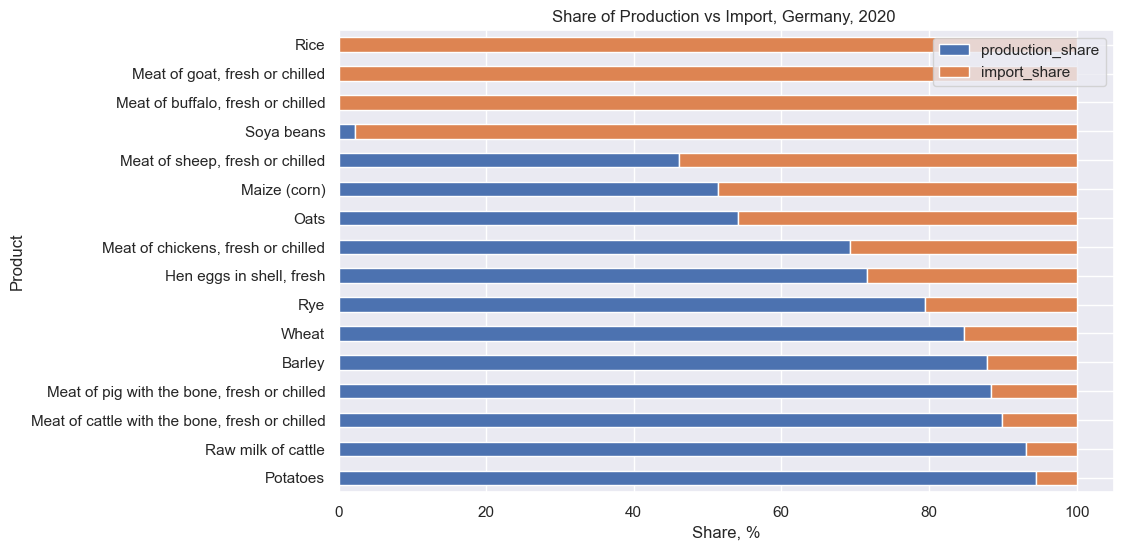

In [166]:
# Filter for 2020
df_trade_prod_ger_2020 = df_trade_prod_ger[df_trade_prod_ger['year'] == 2020]

# Filter for specific items
df_trade_prod_ger_2020_specific = df_trade_prod_ger_2020[df_trade_prod_ger_2020['item'].isin(selected_items)]

# Calculate the share of production and import for each selected product in percentage
df_trade_prod_ger_2020_specific['production_share'] = (df_trade_prod_ger_2020_specific['production_in_t'] / (
        df_trade_prod_ger_2020_specific['production_in_t'] + df_trade_prod_ger_2020_specific['import_quantity'])) * 100
df_trade_prod_ger_2020_specific['import_share'] = (df_trade_prod_ger_2020_specific['import_quantity'] / (
        df_trade_prod_ger_2020_specific['production_in_t'] + df_trade_prod_ger_2020_specific['import_quantity'])) * 100

# Group by product and sum the shares
df_grouped = df_trade_prod_ger_2020_specific.groupby('item')[['production_share', 'import_share']].sum()
df_grouped= df_grouped.sort_values(by='production_share', ascending=False)
# Plotting
ax = df_grouped.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.title('Share of Production vs Import, Germany, 2020 ')
plt.xlabel('Share, %')
plt.ylabel('Product')
plt.legend()
plt.show()

### Emission intensity: production vs import

In [169]:
df_emissions_ger = fs.get_dataframe("SELECT * FROM mk_import_emissions")

In [170]:
df_emissions_ger

,item,import_year,total_import_share,total_import_emission_intensity,total_import_emission_amount
0,Barley,1991,1.0,0.055287,212.018670
1,Barley,1992,1.0,0.059286,256.927590
2,Barley,1993,1.0,0.058420,370.455123
3,Barley,1994,1.0,0.059512,302.021275
4,Barley,1995,1.0,0.060029,322.431067
...,...,...,...,...,...
574,Wheat,2017,1.0,0.070031,751.412322
575,Wheat,2018,1.0,0.070910,764.700478
576,Wheat,2019,1.0,0.069870,786.046080
577,Wheat,2020,1.0,0.069303,598.516504


In [171]:
df_emission_intensity_ger  = pd.merge(df_emissions_ger,df_production_ger_grouped[['item', 'year','emissions_co2eq_combined_in_kt', 'emissions_intensity_combined_in_kg_co2eq_per_kg']], left_on = ['item', 'import_year'], right_on = ['item', 'year'], how = 'left')

In [174]:
df_emission_intensity_ger.head()

,item,import_year,total_import_emission_intensity,total_import_emission_amount,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg
0,Barley,1991,0.055287,212.018670,961.7652,0.0590
1,Barley,1992,0.059286,256.927590,817.9206,0.0596
2,Barley,1993,0.058420,370.455123,738.9506,0.0597
3,Barley,1994,0.059512,302.021275,728.5504,0.0594
4,Barley,1995,0.060029,322.431067,789.9682,0.0591


In [173]:
df_emission_intensity_ger.drop(columns = ['total_import_share', 'year'], inplace = True)

In [180]:
df_emission_intensity_ger.rename(columns={'emissions_co2eq_combined_in_kt': 'total_production_emission_amount', 'emissions_intensity_combined_in_kg_co2eq_per_kg': 'total_production_emissions_intensity'}, inplace = True)

In [219]:
df_emission_intensity_ger_2020

,item,import_year,total_import_emission_intensity,total_import_emission_amount,total_production_emission_amount,total_production_emissions_intensity
29,Barley,2020,0.059449,358.344043,707.8096,0.0584
60,"Beans, dry",2020,0.049358,58.597140,NaN,NaN
91,"Hen eggs in shell, fresh",2020,0.693987,429.573496,501.6761,0.5190
122,Maize (corn),2020,0.053999,569.663437,222.3890,0.0501
153,"Meat of cattle with the bone, fresh or chilled",2020,15.860488,11907.505800,16156.0631,14.7949
184,"Meat of chickens, fresh or chilled",2020,0.229655,300.957858,390.2597,0.3661
215,"Meat of goat, fresh or chilled",2020,10.304400,107.719023,29.4428,0.0000
246,"Meat of pig with the bone, fresh or chilled",2020,1.945802,3170.373042,7552.5807,1.4757
277,"Meat of sheep, fresh or chilled",2020,24.524867,6839.960372,475.9323,11.8983
308,Millet,2020,0.059587,33.621445,NaN,NaN


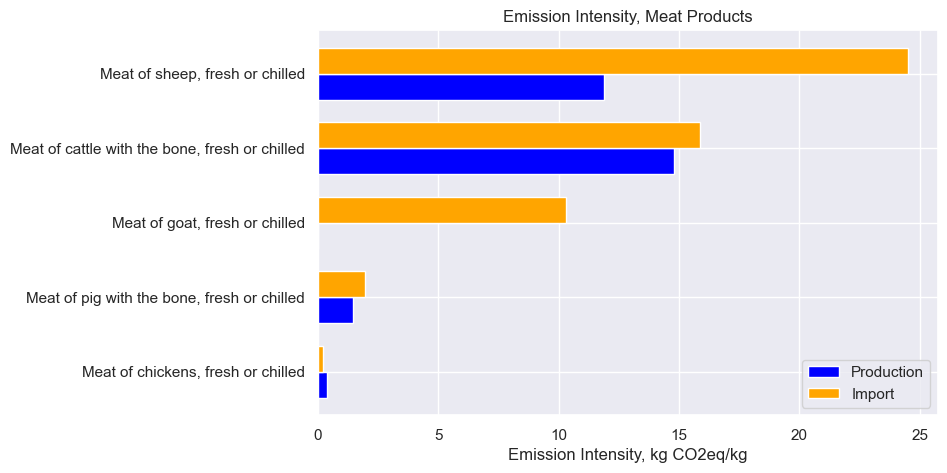

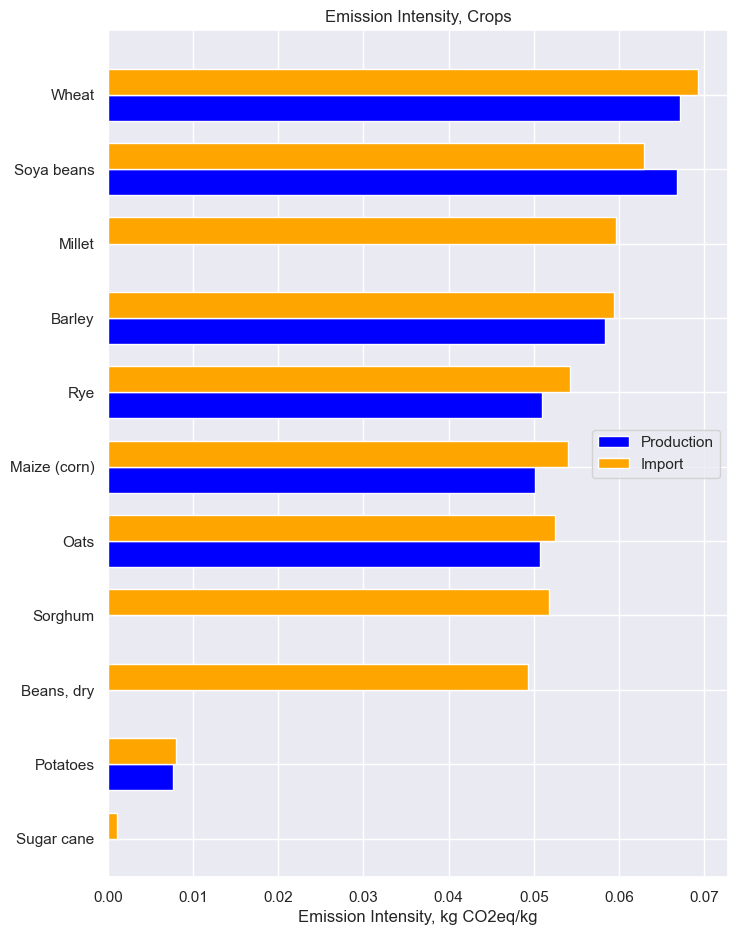

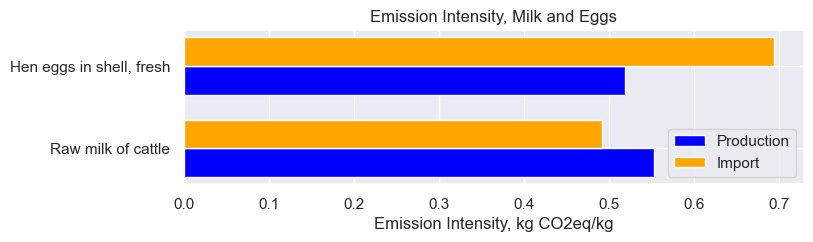

In [234]:

# Function to create horizontal grouped bar chart
def create_grouped_bar_chart(products, title):

    # Filter dataframe based on selected products
    df_selected = df_emission_intensity_ger_2020[df_emission_intensity_ger_2020['item'].isin(products)]

    # Sort the DataFrame based on total_production_emission_amount
    df_selected_sorted = df_selected.sort_values(by='total_import_emission_intensity', ascending=True)

    # Calculate the size based on the number of bars and scale of values
    num_bars = len(df_selected_sorted)
    bar_height = min(0.35, 8 / num_bars)  # Adjust 6 based on your preference for the overall height

    # Calculate the figure size based on the number of bars and scale of values
    fig_size = (8, num_bars * 1)

    plt.figure(figsize=fig_size)

    # Define the index based on the length of the DataFrame
    index = np.arange(len(df_selected_sorted))

    # Plot production emissions
    plt.barh(index, df_selected_sorted['total_production_emissions_intensity'], bar_height, color='blue', label='Production')

    # Plot import emissions
    plt.barh(index + bar_height, df_selected_sorted['total_import_emission_intensity'], bar_height, color='orange', label='Import')

    # Customize the plot
    plt.xlabel('Emission Intensity, kg CO2eq/kg')
    plt.title(title)
    plt.yticks(index + bar_height / 2, df_selected_sorted['item'])
    plt.legend()

    # Show the plot
    plt.show()

# Create separate plots for each product list
create_grouped_bar_chart(selected_meat, 'Emission Intensity, Meat Products')
create_grouped_bar_chart(selected_crops, 'Emission Intensity, Crops')
create_grouped_bar_chart(selected_milk_eggs, 'Emission Intensity, Milk and Eggs')

### Bubble charts

#### Meat emissions

Creating a bubble chart for worldwide meat emissions in 2020.

In [278]:
# Defining new, shorter names for meat food items
def meat_type(food_item):
    if food_item == 'Meat of cattle with the bone, fresh or chilled':
        return 'meat of cattle'
    elif food_item == 'Meat of pig with the bone, fresh or chilled':
        return 'meat of pigs'
    elif food_item == 'Meat of chickens, fresh or chilled':
        return 'meat of chickens'
    return 'meat of other animals'

world_emissions_meat = world_emissions[world_emissions.item_group == 'Meat, Total']
world_emissions_meat['meat_type'] = world_emissions_meat.item.apply(lambda x: meat_type(x))

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_800/3389593957.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_emissions_meat['meat_type'] = world_emissions_meat.item.apply(lambda x: meat_type(x))


In [281]:
meat = world_emissions_meat.meat_type.unique().tolist()
meat

['meat of other animals', 'meat of cattle', 'meat of chickens', 'meat of pigs']

In [255]:
world_emissions_grouped = world_emissions[['item', 'year', 'emissions_co2eq_combined_in_kt']].groupby(['item', 'year'], as_index=False).agg('mean')

In [283]:
world_emissions_grouped_meat = world_emissions_meat[['meat_type', 'year', 'production_in_t', 'emissions_co2eq_combined_in_kt']].groupby(['meat_type', 'year'], as_index=False).agg('sum')

In [343]:
world_emissions_grouped_2020 = world_emissions_grouped_meat[world_emissions_grouped_9['year']== 2020]

In [361]:
world_emissions_grouped_2020_sorted = world_emissions_grouped_2020.sort_values(by='emissions_co2eq_combined_in_kt', ascending=True)

In [362]:
world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'] = \
    world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'].round()

In [363]:
world_emissions_grouped_2020_sorted.head()

,meat_type,year,production_in_t,emissions_co2eq_combined_in_kt
119,meat of chickens,2020,1.204613e+08,64444.0
239,meat of pigs,2020,1.082522e+08,196697.0
179,meat of other animals,2020,2.038452e+07,705021.0
59,meat of cattle,2020,7.159749e+07,2037619.0


In [356]:
# compute circle positions:
circles = circlify.circlify(
    world_emissions_grouped_2020_sorted['emissions_co2eq_combined_in_kt'].tolist(),
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

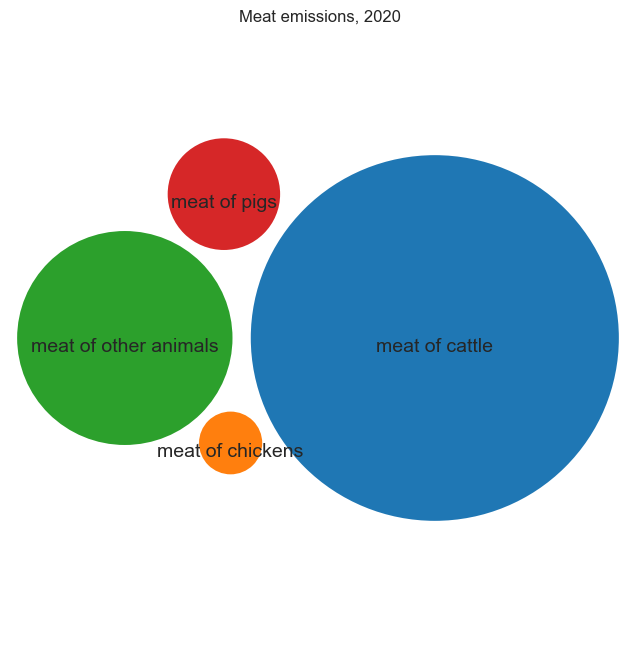

In [383]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Create a list of colors for each label
colors = ['#ff7f0e', '#d62728', '#2ca02c', '#1f77b4']

# Remove axes
ax.axis('off')

# Title
ax.set_title('Meat emissions, 2020')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = world_emissions_grouped_2020_sorted['meat_type']

# print circles
for circle, label, color in zip(circles, labels, colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*0.95, alpha=1, linewidth=2, facecolor=color, edgecolor="white"))
    plt.annotate(
          label, 
          (x,y ) ,
          va='top',
          ha='center',
            fontsize=14
     )

#### Crop emissions

In [386]:
def crop_type(food_item):
    if food_item == 'Rice':
        return 'rice'
    elif food_item == 'Wheat':
        return 'wheat'
    elif food_item == 'Maize (corn)':
        return 'maize'
    elif food_item == 'Sugar cane':
        return 'sugar cane'
    return 'other crops'

world_emissions_crops = world_emissions[world_emissions.item_category == 'Crops, primary']
world_emissions_crops['crop_type'] = world_emissions_crops.item.apply(lambda x: crop_type(x))

/var/folders/r1/n_vkkx7s0c56p3j6pvf4pxf40000gn/T/ipykernel_800/2676505879.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_emissions_crops['crop_type'] = world_emissions_crops.item.apply(lambda x: crop_type(x))


In [387]:
crops = world_emissions_crops.crop_type.unique().tolist()
crops

['other crops', 'maize', 'rice', 'sugar cane', 'wheat']

In [388]:
world_emissions_grouped_crops = world_emissions_crops[['crop_type', 'year', 'production_in_t', 'emissions_co2eq_combined_in_kt']].groupby(['crop_type', 'year'], as_index=False).agg('sum')

In [389]:
world_emissions_grouped_crops.head()

,crop_type,year,production_in_t,emissions_co2eq_combined_in_kt
0,maize,1961,205027246.0,21505.3006
1,maize,1962,204876646.0,21249.7406
2,maize,1963,220228125.0,22501.0850
3,maize,1964,215172401.0,22224.3780
4,maize,1965,226544131.0,22559.5216


In [390]:
world_emissions_grouped_crops_2020 = world_emissions_grouped_crops[world_emissions_grouped_crops['year']== 2020]

In [396]:
world_emissions_grouped_crops_2020_sorted = world_emissions_grouped_crops_2020.sort_values(by='emissions_co2eq_combined_in_kt', ascending=True)

In [397]:
world_emissions_grouped_crops_2020_sorted.head()

,crop_type,year,production_in_t,emissions_co2eq_combined_in_kt
239,sugar cane,2020,1.864663e+09,1658.7174
119,other crops,2020,1.041740e+09,53418.1986
299,wheat,2020,7.569496e+08,64162.5532
59,maize,2020,1.162998e+09,73840.2090
179,rice,2020,7.692280e+08,816502.8020


In [398]:
# compute circle positions:
circles = circlify.circlify(
    world_emissions_grouped_crops_2020_sorted['emissions_co2eq_combined_in_kt'].tolist(),
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

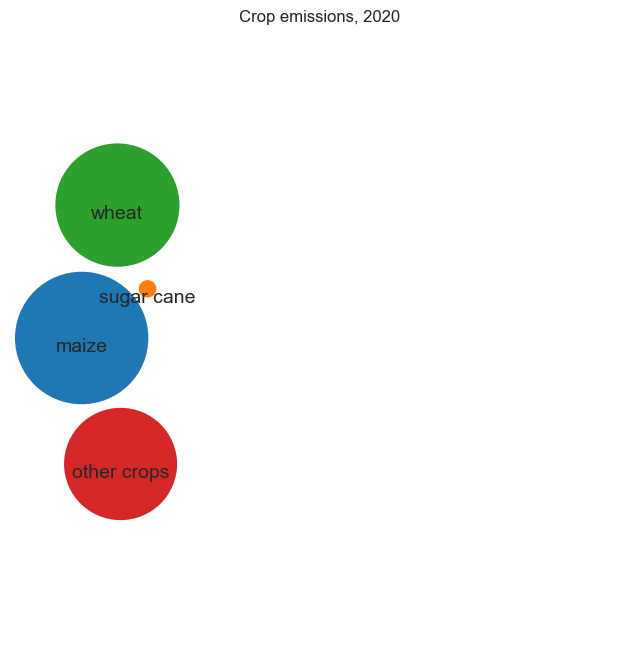

In [399]:
# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(8,8))

# Create a list of colors for each label
colors = ['#ff7f0e', '#d62728', '#2ca02c', '#1f77b4']

# Remove axes
ax.axis('off')

# Title
ax.set_title('Crop emissions, 2020')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = world_emissions_grouped_crops_2020_sorted['crop_type']

# print circles
for circle, label, color in zip(circles, labels, colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r*0.95, alpha=1, linewidth=2, facecolor=color, edgecolor="white"))
    plt.annotate(
          label, 
          (x,y ) ,
          va='top',
          ha='center',
            fontsize=14
     )

### Create a production table

In [220]:
# import production data from database
df_production = fs.get_dataframe('SELECT * FROM production_and_emissions_new')

In [230]:
test= fs.get_dataframe("SELECT * FROM production_and_emissions_new WHERE item = 'Beans, dry' AND country= 'Germany'")

In [231]:
test

,country,continent,subcontinent,special_area,year,population,item,item_code,item_group,item_category,...,emissions_ch4_in_kt,emissions_n2o_in_kt,emissions_co2eq_calc_in_kt,emissions_intensity_calc_in_kg_co2eq_per_kg,source_emissions,emissions_co2eq_in_kt,emissions_intensity_in_kg_co2eq_per_kg,production_emissions_in_t,emissions_co2eq_combined_in_kt,emissions_intensity_combined_in_kg_co2eq_per_kg
0,Germany,Europe,Western Europe,European Union (27),1962,74194417,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0027,0.8046,0.0453,FAO TIER 1,None,None,None,0.8046,0.0453
1,Germany,Europe,Western Europe,European Union (27),1961,73604346,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0022,0.6556,0.0459,FAO TIER 1,None,None,None,0.6556,0.0459
2,Germany,Europe,Western Europe,European Union (27),1963,74796217,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0028,0.8344,0.0438,FAO TIER 1,None,None,None,0.8344,0.0438
3,Germany,Europe,Western Europe,European Union (27),1964,75423245,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0019,0.5662,0.0474,FAO TIER 1,None,None,None,0.5662,0.0474
4,Germany,Europe,Western Europe,European Union (27),1965,76037469,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0013,0.3874,0.0398,FAO TIER 1,None,None,None,0.3874,0.0398
5,Germany,Europe,Western Europe,European Union (27),1967,77173553,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0014,0.4172,0.0391,FAO TIER 1,None,None,None,0.4172,0.0391
6,Germany,Europe,Western Europe,European Union (27),1966,76618716,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0015,0.4470,0.0470,FAO TIER 1,None,None,None,0.4470,0.0470
7,Germany,Europe,Western Europe,European Union (27),1969,78012485,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0012,0.3576,0.0433,FAO TIER 1,None,None,None,0.3576,0.0433
8,Germany,Europe,Western Europe,European Union (27),1968,77646126,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0009,0.2682,0.0378,FAO TIER 1,None,None,None,0.2682,0.0378
9,Germany,Europe,Western Europe,European Union (27),1971,78511398,"Beans, dry",176,"Pulses, Total","Crops, primary",...,0.0,0.0015,0.4470,0.0379,FAO TIER 1,None,None,None,0.4470,0.0379


In [221]:
df_production['item'].unique()

array(['Groundnuts, excluding shelled', 'Hen eggs in shell, fresh',
       'Horse meat, fresh or chilled', 'Horses', 'Jojoba seeds',
       'Leeks and other alliaceous vegetables', 'Lemons and limes',
       'Lentils, dry', 'Lettuce and chicory', 'Linseed',
       'Locust beans (carobs)', 'Maize (corn)',
       'Mangoes, guavas and mangosteens', 'Margarine and shortening',
       'Meat of cattle with the bone, fresh or chilled',
       'Meat of chickens, fresh or chilled',
       'Meat of goat, fresh or chilled',
       'Meat of pig with the bone, fresh or chilled',
       'Meat of rabbits and hares, fresh or chilled',
       'Meat of sheep, fresh or chilled',
       'Meat of turkeys, fresh or chilled', 'Melonseed', 'Millet',
       'Molasses', 'Mules and hinnies', 'Mustard seed', 'Natural honey',
       'Natural rubber in primary forms', 'Oats', 'Oil of linseed',
       'Oil of maize', 'Oil of palm kernel', 'Oil of sesame seed',
       'Oil palm fruit', 'Okra', 'Olive oil', 'Olives',


In [ ]:
df_production.head()

### Emissions and production development over time

In [ ]:
# Create a list of items in the 'livestock_primary' category
livestock_primary = list(set(df_production[(df_production['item_category'] == 'Livestock primary') & (df_production['emissions_intensity_combined_in_kg_co2eq_per_kg'].notna())]['item'].tolist()))

In [ ]:
# Create two separate lists for milk and meat items
livestock_meat = ['Meat of cattle with the bone, fresh or chilled',
 'Meat of buffalo, fresh or chilled',
 'Meat of pig with the bone, fresh or chilled',
 'Meat of sheep, fresh or chilled',
 'Meat of chickens, fresh or chilled',
 'Meat of goat, fresh or chilled']

livestock_milk = ['Raw milk of buffalo','Raw milk of goats','Raw milk of camel','Raw milk of sheep','Raw milk of cattle']

In [ ]:
# Create a list of items in the 'crops_primary' category
crops_primary = list(set(df_production[(df_production['item_category'] == 'Crops, primary') & (df_production['emissions_intensity_combined_in_kg_co2eq_per_kg'].notna())]['item'].tolist()))

In [ ]:
# Remove rice from the list
crops_primary_wo_rice = ['Maize (corn)','Sugar cane','Barley','Potatoes','Millet','Wheat','Soya beans','Rye','Oats','Sorghum','Beans, dry']

In [ ]:
# Create a list for remaining items
rice_and_eggs = ['Hen eggs in shell, fresh', 'Rice']

In [ ]:
emissions_intensity = df_production[['item', 'year', 'emissions_intensity_combined_in_kg_co2eq_per_kg']].groupby(['item', 'year'], as_index=False).agg('median')

In [ ]:
emissions_intensity = emissions_intensity.dropna(subset=['emissions_intensity_combined_in_kg_co2eq_per_kg'])

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18) )

# Iterate over livestock_meat items
for item in livestock_meat:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[0,0], label=item)

axes[0,0].legend()
axes[0,0].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[0,0].set_title('Meat')

# Iterate over livestock_meat items
for item in livestock_milk:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[0,1], label=item)

axes[0,1].legend()
axes[0,1].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[0,1].set_title('Dairy')

# Iterate over crop items
for item in crops_primary_wo_rice:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[1,0], label=item)

axes[1,0].legend()
axes[1,0].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[1,0].set_title('Crops')

# Iterate over other items
for item in rice_and_eggs:
    item_data = emissions_intensity[emissions_intensity['item'] == item]
    item_data.plot(x='year', y='emissions_intensity_combined_in_kg_co2eq_per_kg', ax=axes[1,1], label=item)

axes[1,1].legend()
axes[1,1].set_ylabel('Emission Intensity, kg CO2eq/kg product')
axes[1,1].set_title('Other')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

We see an overall decrease in emission intensity among different product groups. This trend is especially strong for rice, eggs and some of the meat products.

In [ ]:
# Calculate total production amount per item and year
production_amount_item = df_production[['item', 'year', 'production_in_t']].groupby(['item', 'year'], as_index=False).agg('sum')

In [ ]:
production_amount_item.head()

At the same time, production of these items is growing rapidly, driven by the population growth. 
This is especially true for widely consumed items such as pork, beef and chicken meat, rice, sugar cane and cattle milk. 

In [ ]:
# Plot production development of meat and crop food items over time. 
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 18) )

# Iterate over livestock_meat items
for item in livestock_meat:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[0,0], label=item)

axes[0,0].legend()
axes[0,0].set_ylabel('Production, t')
axes[0,0].set_title('Meat')

# Iterate over livestock_meat items
for item in livestock_milk:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[0,1], label=item)

axes[0,1].legend()
axes[0,1].set_ylabel('Production, t')
axes[0,1].set_title('Dairy')

# Iterate over crop items
for item in crops_primary_wo_rice:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[1,0], label=item)

axes[1,0].legend()
axes[1,0].set_ylabel('Production, t')
axes[1,0].set_title('Crops')

# Iterate over other items
for item in rice_and_eggs:
    item_data = production_amount_item[production_amount_item['item'] == item]
    item_data.plot(x='year', y='production_in_t', ax=axes[1,1], label=item)

axes[1,1].legend()
axes[1,1].set_ylabel('Production, t')
axes[1,1].set_title('Other')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

### Production by country

In [ ]:
production_amount_country = df_production[(df_production['area_group'] == 'no') & (df_production['area'] != 'China')]\
    [['area', 'population', 'production_in_t']]\
    .groupby(['area'], as_index=False)\
    .agg('sum')

In [ ]:
# Calculating production per capita
production_amount_country['production_per_capita'] = production_amount_country['production_in_t'] / production_amount_country['population']

In [ ]:
production_amount_country.head()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plot the top-10 agricultural producers by total production
production_amount_country.sort_values(by='production_in_t', ascending=False)\
    .head(10).plot.bar(x='area', y='production_in_t', ax=axes[0], logy=False)
axes[0].set_title('Top-10 food producers by total production')
axes[0].get_legend().remove()
axes[0].set_ylabel('t')

# Plot the top-10 agricultural producers by production per capita
production_amount_country.sort_values(by='production_per_capita', ascending=False)\
    .head(10).plot.bar(x='area', y='production_per_capita', ax=axes[1], logy=False)
axes[1].set_title('Top-10 food producers by production per capita')
axes[1].get_legend().remove()
axes[1].set_ylabel('t / capita')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### Emissions by country

In [ ]:
production_amount_country = df_production[(df_production['area_group'] == 'no') & (df_production['area'] != 'China')]\
    [['area', 'population', 'emissions_co2eq_in_kt']]\
    .groupby(['area'], as_index=False)\
    .agg('sum')

In [ ]:
# Calculating emissions per capita
production_amount_country['emissions_per_capita'] = production_amount_country['emissions_co2eq_in_kt'] / production_amount_country['population']

In [ ]:
# Plot the top-10 countries by emission amount
fig, ax = plt.subplots(figsize=(3, 3))
production_amount_country.sort_values(by='emissions_co2eq_in_kt', ascending=False)\
    .head(10).plot.bar(x='area', y='emissions_co2eq_in_kt', ax=ax, logy=True)
ax.set_title('Top-10 countries by emission amount')
ax.get_legend().remove()
ax.set_ylabel('t')
plt.show()

In [ ]:
# Plot the top-10 countries by emission amount per capita
fig, ax = plt.subplots(figsize=(3, 3))
production_amount_country.sort_values(by='emissions_per_capita', ascending=False)\
    .head(10).plot.bar(x='area', y='emissions_per_capita', ax=ax, logy=True)
ax.set_title('Top-10 countries by emission per capita amount')
ax.get_legend().remove()
ax.set_ylabel('t')
plt.show()